In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from ignite.metrics import Accuracy, ConfusionMatrix, IoU, mIoU
from tqdm import tqdm
import logging
import sys
sys.path.append('/home/lindi/chenhr/threed/pointnet++/seg')
from dataset import S3dis
from data_aug import *
import fps_cuda
import seaborn as sns
import matplotlib.pyplot as plt
from memorynet_seg_x3x2_contrast import Memorynet
from sklearn.manifold import TSNE

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def gen_color(y):
    """
    y.shape = (n,) cuda
    """
    y = y.to('cpu').squeeze()
    color_map = [[0, 255, 0], [0, 0, 255], [136, 206, 250],
                 [255, 255, 0], [255, 0, 255], [255, 0, 0],
                 [107, 142, 35], [255, 165, 0], [153, 50, 204],
                 [139, 26, 26], [0, 100, 0], [156, 156, 156], [0, 0, 0]]
    color_map = torch.as_tensor(color_map, dtype=torch.float32)
    res = torch.zeros((len(y), 3))
    for i in range(13):
        mask = (y == i)
        res[mask] = color_map[i]
    return res

In [3]:
device = 'cuda:7'

model = Memorynet(13).to(device)
model_path = '/home/lindi/chenhr/threed/pointnet++/seg/checkpoints/memorynet_seg_x3x2_contrast_length128.pth'
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()

memory = model.memory2.memory
labels = torch.arange(0, 13, 1).unsqueeze(dim=1).expand(-1, memory.shape[1])

memory = memory.flatten(0, 1).to('cpu')
labels = labels.flatten(0, 1)

colors = gen_color(labels) / 255

print(memory.shape, colors.shape)

torch.Size([1664, 256]) torch.Size([1664, 3])


In [4]:
memory = memory.numpy()
labels = labels.numpy()

/home/lindi/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


([], [])

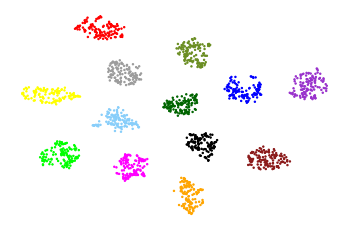

In [5]:
tsne = TSNE(init='pca', learning_rate='auto', n_iter=300)
low_f = tsne.fit_transform(memory)

plt.scatter(low_f[:, 0], low_f[:, 1], c=colors, s=2)
plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.savefig('./epsc.png', dpi=800)